## Прогнозирование ряда со сложной сезонностью

In [1]:
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import warnings
from itertools import product

%pylab inline
import pandas as pd
from scipy import stats
import statsmodels
import statsmodels.api as sm
import matplotlib.pyplot as plt

C:\ProgramData\Anaconda2\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Populating the interactive namespace from numpy and matplotlib


C:\ProgramData\Anaconda2\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['product']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"
C:\ProgramData\Anaconda2\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# Нью-Йорк вписан в прямоугольник от -74.25559 до -73.70001 градусов долготы и от 40.49612 до 40.91553 широты. 
NY = (-74.25559, -73.70001, 40.49612, 40.91553)

Выберем зону, где находится Эмпайр-Стейт-Билдинг

In [3]:
# Номер ячейки Эмпайр-Стейт-Билдинг с координатами(-40.747780, -73.985830)
X = [-73.985428]
Y = [40.748817]
bin_count = 50

bin_stat = stats.binned_statistic_2d(X, Y, None, statistic='count',
                                     bins=bin_count,
                                     range=[[NY[0], NY[1]], [NY[2], NY[3]]],
                                     expand_binnumbers=True)
regions = (bin_stat.binnumber[0] - 1) * bin_count + bin_stat.binnumber[1]
ESB_region = regions[0]

#### Загрузка, обработка и агрегация данных 

In [4]:
def aggregate_data(fname):
    # Загрузка данных
    data = pd.read_csv(fname, header = 0, sep=',')

    # ФИЛЬТРАЦИЯ
    # Удаление поездок с нулевой длительностью
    data.drop(data[data['tpep_pickup_datetime'] == data['tpep_dropoff_datetime']].index, axis=0, inplace=True)
    data.drop(data[data['tpep_pickup_datetime'] > data['tpep_dropoff_datetime']].index, axis=0, inplace=True)

    # Удаление поездок с нулевым количеством пассажиров
    data.drop(data[data['passenger_count'] == 0].index, axis=0, inplace=True)

    # Удаление поездок с нулевым расстоянием поездки по счётчику
    data.drop(data[data['trip_distance'] == 0].index, axis=0, inplace=True)

    # Удаление поездок с координатами начала, не попадающими в прямоугольник Нью-Йорка
    data.drop(data[(data['pickup_longitude'] < -74.25559) | (data['pickup_longitude']  > -73.70001) | (data['pickup_latitude']  < 40.49612) | (data['pickup_latitude']  > 40.91553)].index, axis=0, inplace=True)

    # Новый столбец date, показывает час начала поездки
    data.insert(1, 'timestamp', data.tpep_pickup_datetime.apply(lambda x : x.split(':')[0]))

    X = data.pickup_longitude
    Y = data.pickup_latitude
    bin_stat = stats.binned_statistic_2d(X, Y, None, statistic='count',
                                         bins=bin_count,
                                         range=[[NY[0], NY[1]], [NY[2], NY[3]]],
                                         expand_binnumbers=True)
    regions = (bin_stat.binnumber[0] - 1) * bin_count + bin_stat.binnumber[1]

    # Добавим еще один столбец - регион начала поездки
    data.insert(1, 'region_id', regions)

    # Выбираем одну из зон (Эмпайр-Стейт-Билдинг)
    data = data.loc[data['region_id'] == ESB_region]

    # Теперь собираем аггрегированную таблицу из трех столбцов: дата, час, номер ячейки, 
    # количество поездок из этой ячейки в этот час в эту дату
    data_agg = data[['timestamp','region_id']].groupby(['region_id', 'timestamp']).size().reset_index(name='counts')

    # Сохраняем
    data_agg.to_csv('data_agg_ESB.csv', sep = ',', index = False, mode = 'a')

### Вспомогательные функции

#### Проверка гипотез

In [5]:
def Hypothesis_testing(X):
    p = sm.tsa.stattools.adfuller(X)[1]
    print("Критерий Дики-Фуллера: p=%f, %s гипотезу о нестационарности" % (p,"не отвергает" if p >= 0.05 else "отвергает"))
    
    p2 = statsmodels.stats.diagnostic.acorr_ljungbox(X)[1]
    print ("Q-тест Льюнг — Бокса случайности данных: p=%f, %s гипотезу о случайности данных" % (sum(p2<0.05), "не отвергает" if sum(p2<0.05) == 0 else "отвергает"))
    
    p3 = stats.ttest_1samp(X, 0)[1]
    print ("Критерий Стьюдента для несмещенности: p=%f, %s гипотезу равенства среднего 0" % (p3, "не отвергает" if p3 >= 0.05 else "отвергает"))

#### QQ-график и Остатки

In [6]:
def QQ_chart_and_residuals(X):
    plt.figure(figsize(15,5))
    plt.subplot(121)
    sc.stats.probplot(X, dist="norm", plot=pylab)

    plt.subplot(122)
    np.log(X).plot.hist()
    plt.xlabel('Residuals', fontsize=10)
    pylab.show()

#### ACF и PACF

In [7]:
def ACF_PACF(X, zero=True):
    plt.figure(figsize(15,8))
    ax = plt.subplot(211)
    sm.graphics.tsa.plot_acf(X, lags=168, ax=ax)
    pylab.show()
    
    ax = plt.subplot(212)
    sm.graphics.tsa.plot_pacf(X, lags=168, ax=ax)
    pylab.show()

#### Подготовим данные за полгода: январь 2016 - май 2016 гг.

In [8]:
%%time

aggregate_data('yellow_tripdata_2016-01.csv')
aggregate_data('yellow_tripdata_2016-02.csv')
aggregate_data('yellow_tripdata_2016-03.csv')
aggregate_data('yellow_tripdata_2016-04.csv')
aggregate_data('yellow_tripdata_2016-05.csv')

Wall time: 10min 28s


In [9]:
data_agg_ESB = pd.read_csv('data_agg_ESB.csv', header = 0, sep=',', index_col=['timestamp'], parse_dates=['timestamp'])

# Удаляем лишние заголовки
data_agg_ESB.drop(data_agg_ESB.loc[data_agg_ESB['region_id'] == 'region_id'].index, axis = 0, inplace = True)

# Убираем индекс зоны, поскольку мы выбрали одну конкретную
data_agg_ESB.drop(['region_id'], axis=1, inplace=True)

# Приводим к необходимому типу данных
data_agg_ESB['counts'] = pd.to_numeric(data_agg_ESB['counts'])
data_agg_ESB.index = pd.to_datetime(data_agg_ESB.index)

data_agg_ESB.head()

counts
timestamp                  
2016-05-01 00:00:00     881
2016-05-01 01:00:00     713
2016-05-01 02:00:00     533
2016-05-01 03:00:00     418
2016-05-01 04:00:00     353

Наш ряд выглядит так:

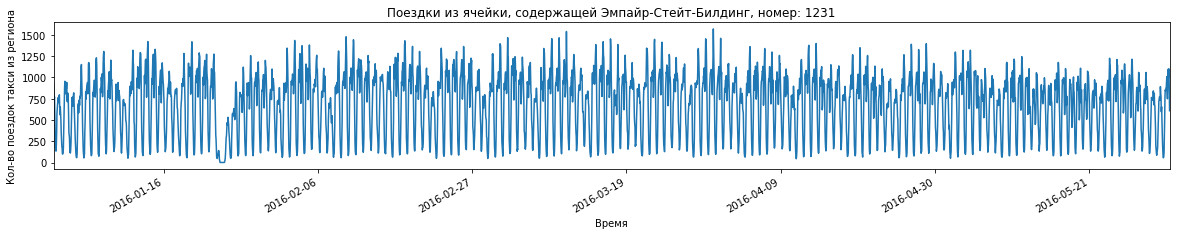

In [10]:
plt.figure(figsize(20,3))
data_agg_ESB['counts'].plot()
plt.xlabel(u'Время')
plt.ylabel(u'Кол-во поездок такси из региона')
plt.title(u'Поездки из ячейки, содержащей Эмпайр-Стейт-Билдинг, номер: %i' % ESB_region)
pylab.show()

Хочется обратить внимание на нулевое количество поездок в конце января 2016, возможно, аномалия, но, скорее всего, сбой в работе.

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


Text(0,0.5,u'\u041a\u043e\u043b-\u0432\u043e \u043f\u043e\u0435\u0437\u0434\u043e\u043a \u0442\u0430\u043a\u0441\u0438 \u0438\u0437 \u0440\u0435\u0433\u0438\u043e\u043d\u0430')

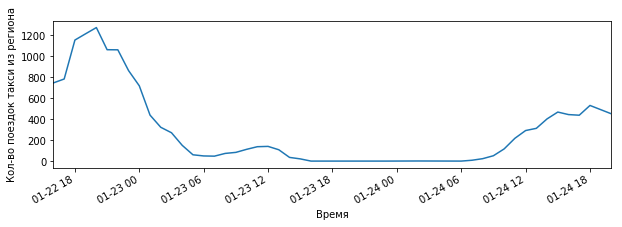

In [11]:
plt.figure(figsize(10,3))
data_agg_ESB['counts'].ix['22-01-2016 16:00':'24-01-2016 20:00'].plot()
plt.xlabel(u'Время')
plt.ylabel(u'Кол-во поездок такси из региона')

Создаём регрессионные признаки для учёта недельной сезонности

In [12]:
K=4
p = 2.*pi/168. # 168 — длительность недели в часах
for T in range(1, K+1):
    phi = p*T
    data_agg_ESB['s'+str(T)] = sin(T*phi)
    data_agg_ESB['c'+str(T)] = cos(T*phi)
data_agg_ESB.head()

counts        s1        c1        s2        c2        s3  \
timestamp                                                                       
2016-05-01 00:00:00     881  0.037391  0.999301  0.149042  0.988831  0.330279   
2016-05-01 01:00:00     713  0.037391  0.999301  0.149042  0.988831  0.330279   
2016-05-01 02:00:00     533  0.037391  0.999301  0.149042  0.988831  0.330279   
2016-05-01 03:00:00     418  0.037391  0.999301  0.149042  0.988831  0.330279   
2016-05-01 04:00:00     353  0.037391  0.999301  0.149042  0.988831  0.330279   

                           c3       s4        c4  
timestamp                                         
2016-05-01 00:00:00  0.943883  0.56332  0.826239  
2016-05-01 01:00:00  0.943883  0.56332  0.826239  
2016-05-01 02:00:00  0.943883  0.56332  0.826239  
2016-05-01 03:00:00  0.943883  0.56332  0.826239  
2016-05-01 04:00:00  0.943883  0.56332  0.826239

In [13]:
#K = 4
#for i in range(1, K + 1):
#    data_agg_ESB['s%d' % i] = np.fromfunction(lambda x: np.sin((x + 1) * 2 * np.pi * i / 168.0), (len(data_agg_ESB),))
#    data_agg_ESB['c%d' % i] = np.fromfunction(lambda x: np.cos((x + 1) * 2 * np.pi * i / 168.0), (len(data_agg_ESB),))
#data_agg_ESB.head()

Сделаем регрессию целевого признака — количества поездок — на построенные признаки, и посмотрим на остатки регрессии

In [14]:
model = smf.ols('counts ~ s1 + c1 + s2 + c2 + s3 + c3 + s4 + c4', data_agg_ESB)
regress_model = model.fit()
print(regress_model.summary())

                            OLS Regression Results                            
Dep. Variable:                 counts   R-squared:                      -0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                   -0.2726
Date:                Tue, 03 Jul 2018   Prob (F-statistic):               1.00
Time:                        17:46:17   Log-Likelihood:                -63788.
No. Observations:                8762   AIC:                         1.276e+05
Df Residuals:                    8759   BIC:                         1.276e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.092e+12   6.95e+12      0.301      0.7

Посмотрим на остатки

Text(0.5,0,u'\u0412\u0440\u0435\u043c\u044f')

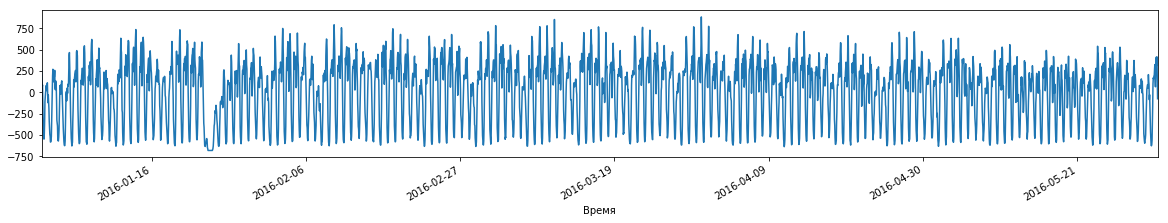

In [15]:
plt.figure(figsize=(20, 3))
regress_model.resid.plot()
plt.xlabel(u'Время')

In [16]:
Hypothesis_testing(regress_model.resid)

Критерий Дики-Фуллера: p=0.000000, отвергает гипотезу о нестационарности
Q-тест Льюнг — Бокса случайности данных: p=40.000000, отвергает гипотезу о случайности данных
Критерий Стьюдента для несмещенности: p=0.460267, не отвергает гипотезу равенства среднего 0


C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log
  import sys


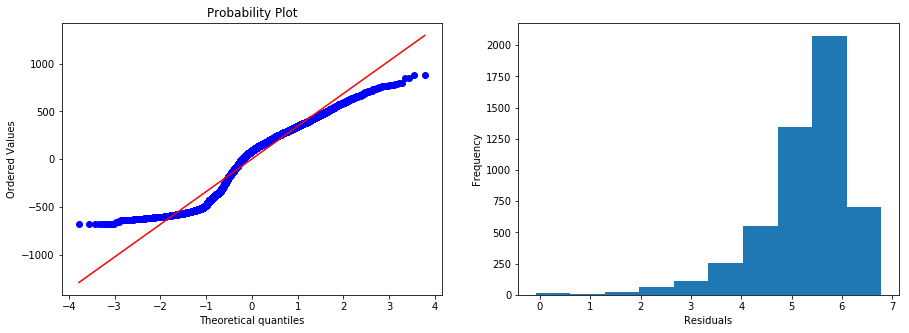

In [17]:
# QQ график и Остатки
QQ_chart_and_residuals(regress_model.resid)

Теперь посмотрим на результат Линейной регрессии LinearRegression() из LinearRegression()

In [18]:
# Модель
lr = LinearRegression()
lr.fit(data_agg_ESB.iloc[:, 1:], data_agg_ESB.counts)
predictions = lr.predict(data_agg_ESB.iloc[:, 1:])
residuals = data_agg_ESB.counts - predictions

Text(0.5,0,u'\u0412\u0440\u0435\u043c\u044f')

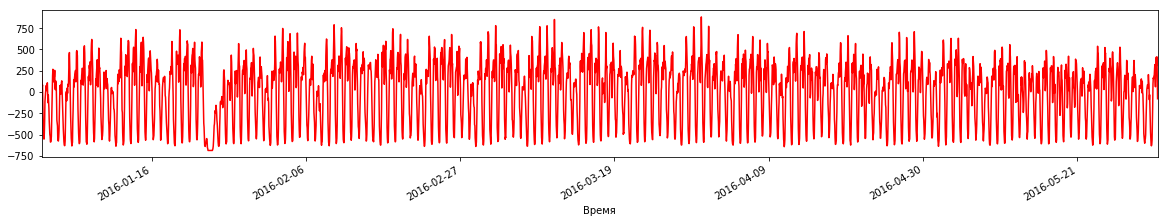

In [19]:
plt.figure(figsize=(20,3))
residuals.plot(color='red')
plt.xlabel(u'Время')

In [20]:
Hypothesis_testing(residuals)

Критерий Дики-Фуллера: p=0.000000, отвергает гипотезу о нестационарности
Q-тест Льюнг — Бокса случайности данных: p=40.000000, отвергает гипотезу о случайности данных
Критерий Стьюдента для несмещенности: p=1.000000, не отвергает гипотезу равенства среднего 0


C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log
  import sys


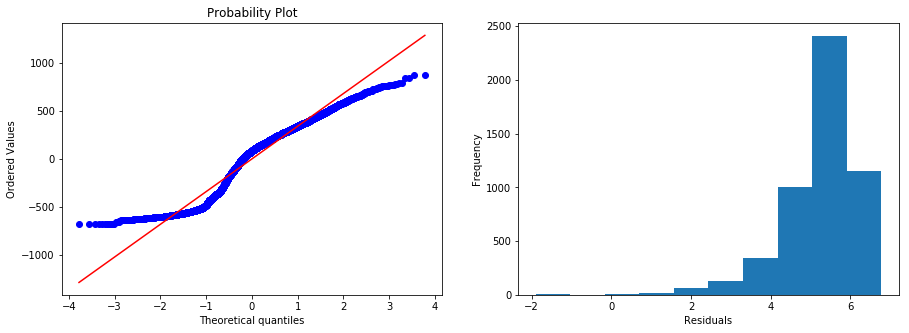

In [21]:
# QQ график и Остатки
QQ_chart_and_residuals(residuals)

In [22]:
data_agg_ESB['residuals'] = residuals
data_agg_ESB.head()

counts        s1        c1        s2        c2        s3  \
timestamp                                                                       
2016-05-01 00:00:00     881  0.037391  0.999301  0.149042  0.988831  0.330279   
2016-05-01 01:00:00     713  0.037391  0.999301  0.149042  0.988831  0.330279   
2016-05-01 02:00:00     533  0.037391  0.999301  0.149042  0.988831  0.330279   
2016-05-01 03:00:00     418  0.037391  0.999301  0.149042  0.988831  0.330279   
2016-05-01 04:00:00     353  0.037391  0.999301  0.149042  0.988831  0.330279   

                           c3       s4        c4   residuals  
timestamp                                                     
2016-05-01 00:00:00  0.943883  0.56332  0.826239  194.148824  
2016-05-01 01:00:00  0.943883  0.56332  0.826239   26.148824  
2016-05-01 02:00:00  0.943883  0.56332  0.826239 -153.851176  
2016-05-01 03:00:00  0.943883  0.56332  0.826239 -268.851176  
2016-05-01 04:00:00  0.943883  0.56332  0.826239 -333.851176

Из-за большого количества аномальных дней (праздники и т.д.) вряд ли удастся сделать так, что критерий Дики-Фуллера не будет отвергать гипотезу нестационарности, поэтому при выборе порядка дифференцирования ориентируйтесь в первую очередь на результат STL-декомпозиции.

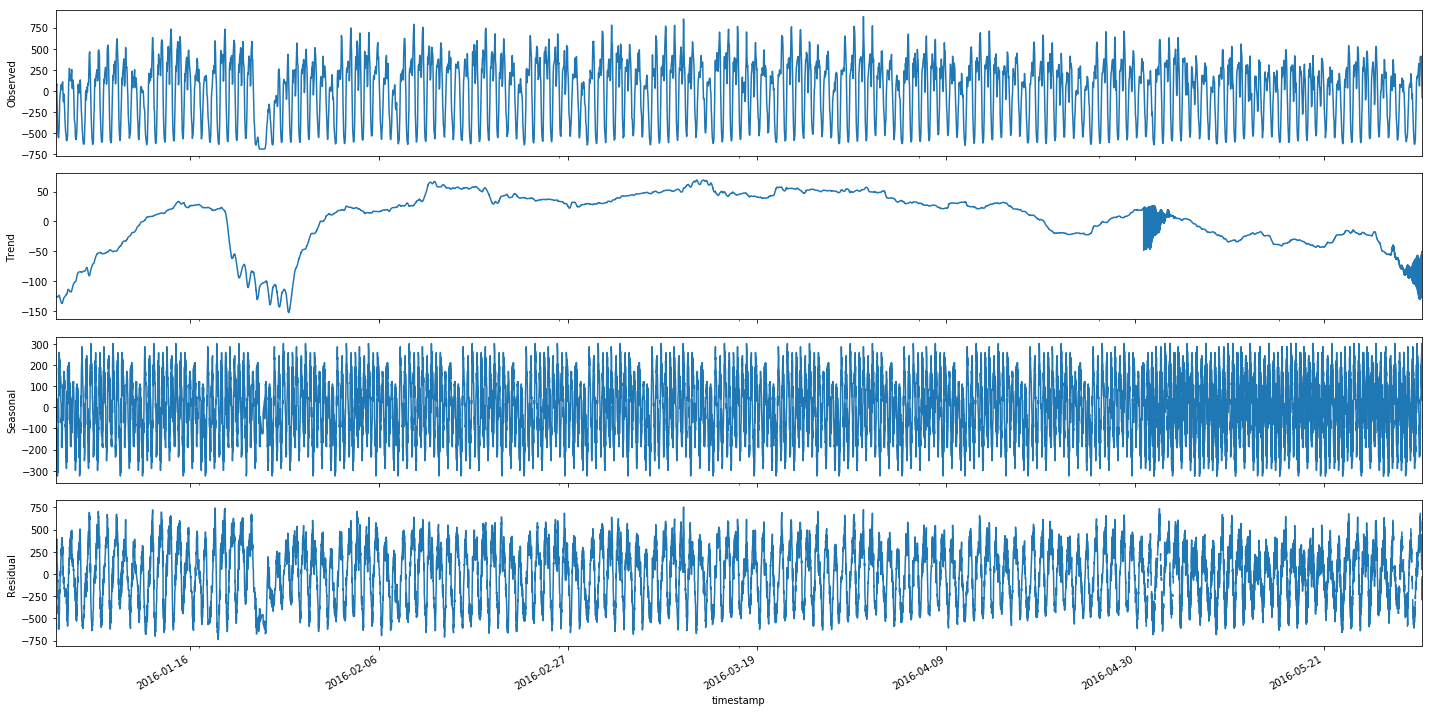

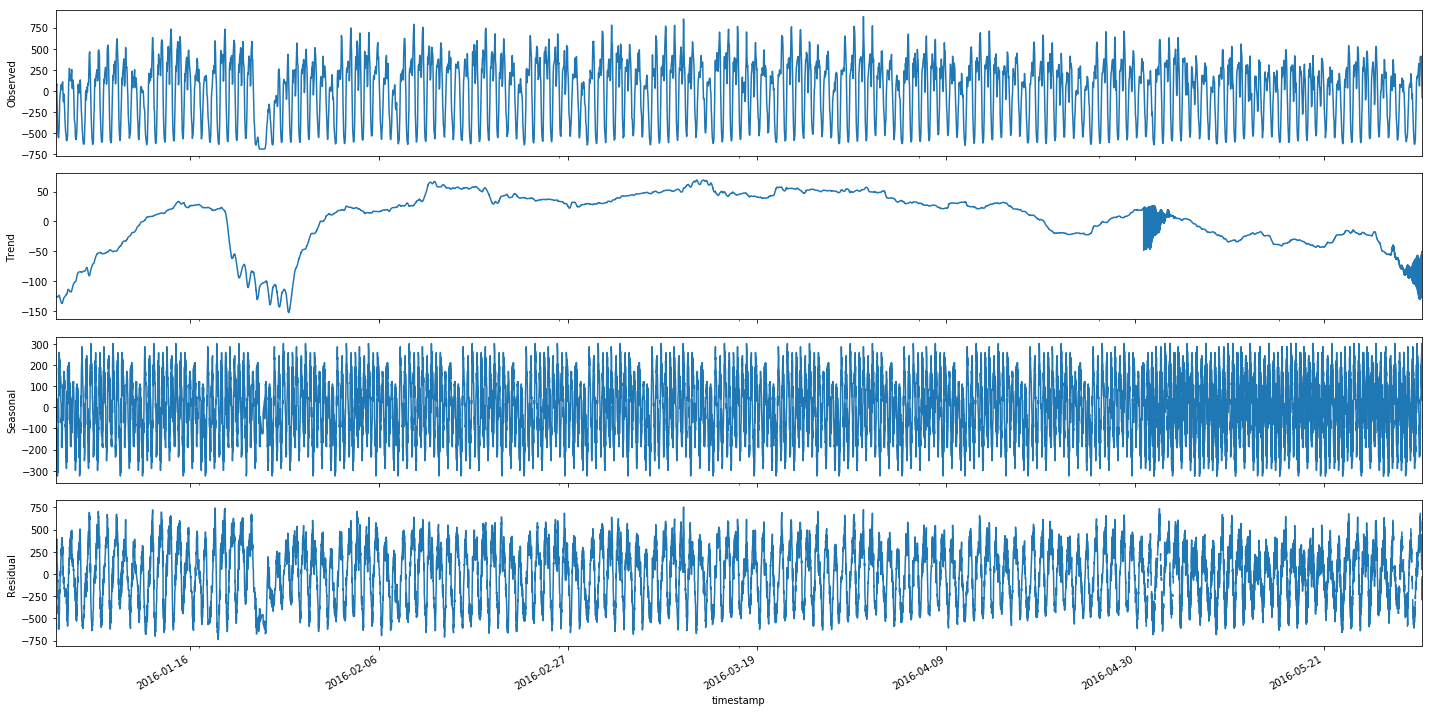

In [23]:
plt.figure(figsize(20,10))
sm.tsa.seasonal_decompose(data_agg_ESB['residuals'], freq = 168).plot()

По критерию Дики-Фуллера гипотезу о нестационарности отвергается, но по графикам видно что это не так.

Критерий Дики-Фуллера: p=0.000000


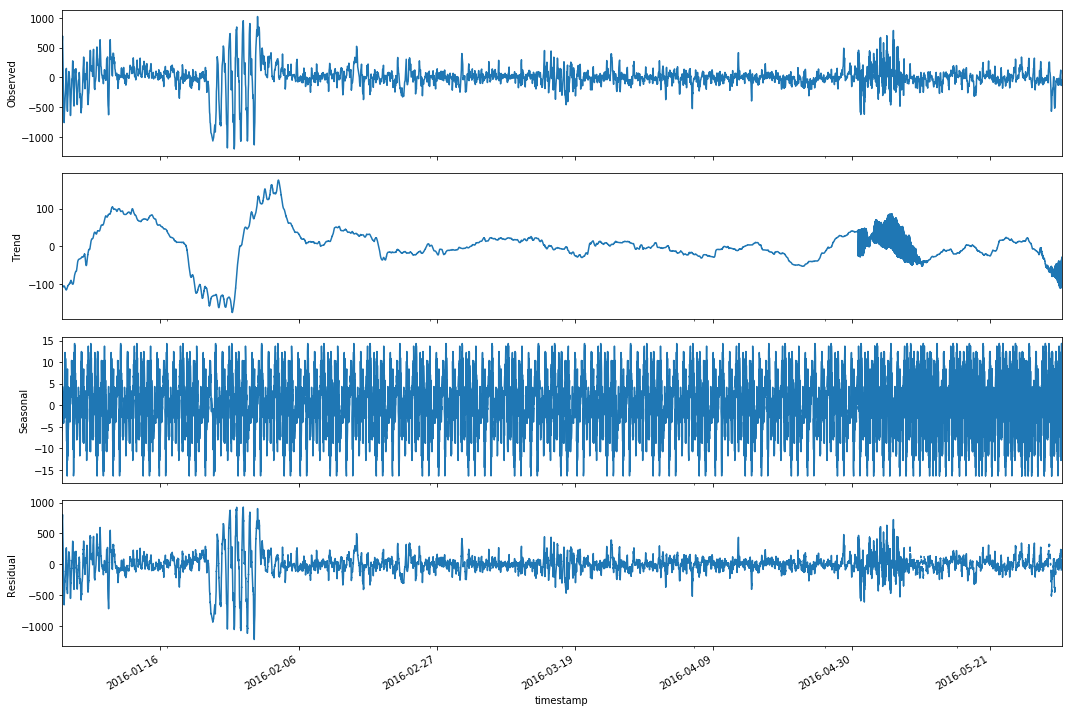

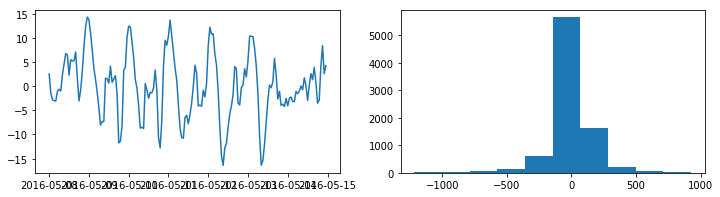

In [24]:
# Выполним сезонное дифференцирование (сезон - неделя)
data_agg_ESB['diff_168'] = data_agg_ESB['residuals'] - data_agg_ESB['residuals'].shift(168)
    
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data_agg_ESB['diff_168'][168:], freq = 168).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data_agg_ESB['diff_168'][168:])[1])
    
fig = plt.figure(figsize = (12,3))
ax = fig.add_subplot(121)
plt.plot(sm.tsa.seasonal_decompose(data_agg_ESB['diff_168'][168:], freq = 168).seasonal[:168])
ax = fig.add_subplot(122)
plt.hist(sm.tsa.seasonal_decompose(data_agg_ESB['diff_168'][168:], freq = 168).resid[84:-84])
plt.show()

Критерий Дики-Фуллера: p=0.000000


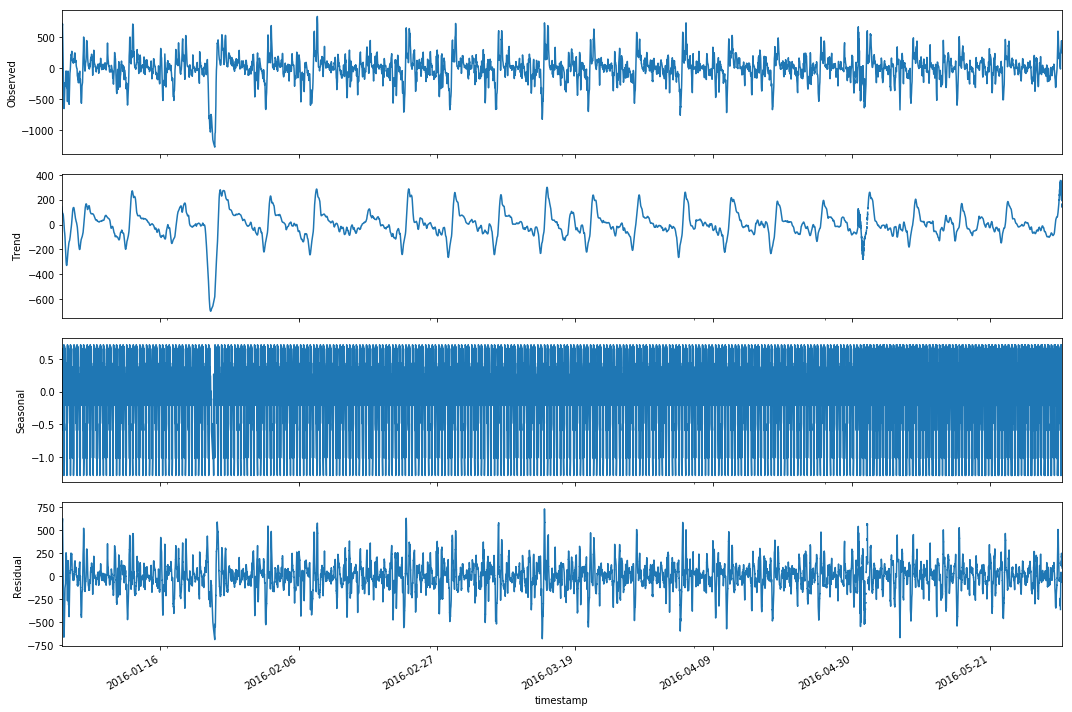

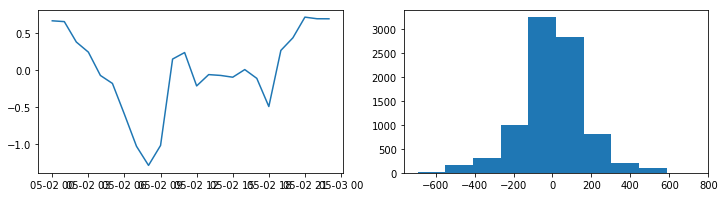

In [25]:
# Выполним еще раз сезонное дифференцирование, на этот раз суточное
data_agg_ESB['diff_24'] = data_agg_ESB['residuals'] - data_agg_ESB['residuals'].shift(24)
    
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data_agg_ESB['diff_24'][24:], freq = 24).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data_agg_ESB['diff_24'][24:])[1])
    
fig = plt.figure(figsize = (12,3))
ax = fig.add_subplot(121)
plt.plot(sm.tsa.seasonal_decompose(data_agg_ESB['diff_24'][24:], freq = 24).seasonal[:24])
ax = fig.add_subplot(122)
plt.hist(sm.tsa.seasonal_decompose(data_agg_ESB['diff_24'][24:], freq = 24).resid[12:-12])
plt.show()

Критерий Дики-Фуллера: p=0.000000


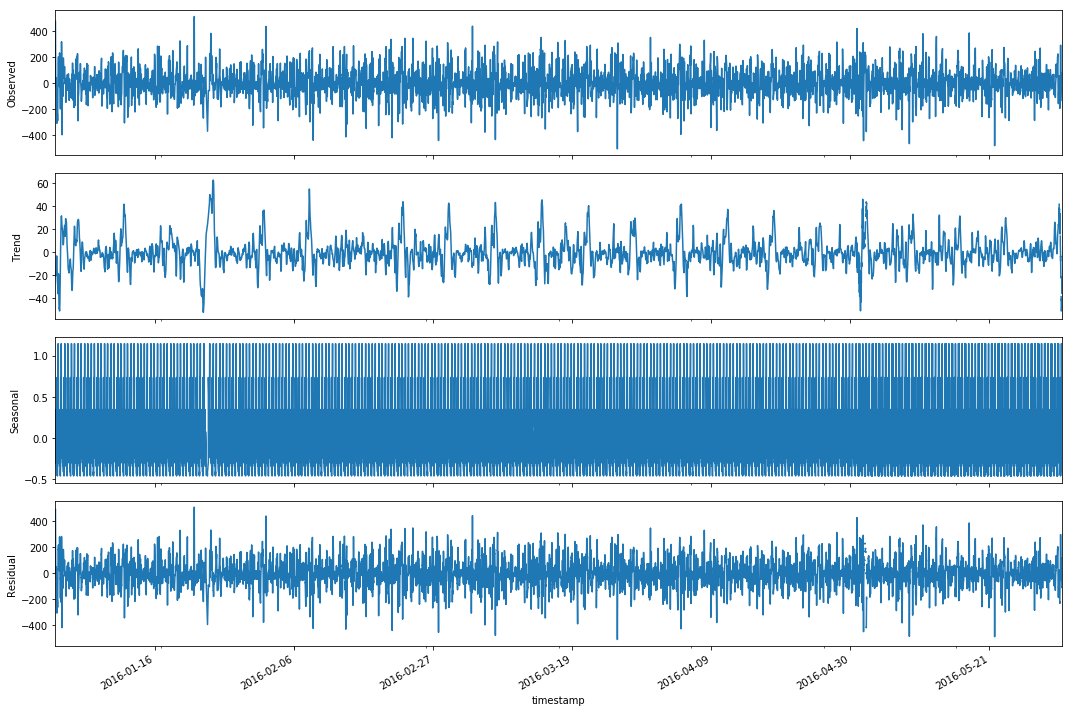

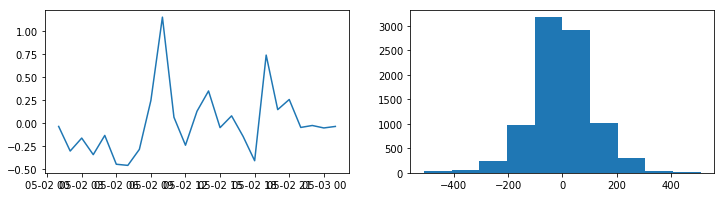

In [26]:
# И наконец, обычное дифференцирование
data_agg_ESB['diff_'] = data_agg_ESB['diff_24'] - data_agg_ESB['diff_24'].shift(1)
    
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data_agg_ESB['diff_'][25:], freq = 24).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data_agg_ESB['diff_'][25:])[1])
    
fig = plt.figure(figsize = (12,3))
ax = fig.add_subplot(121)
plt.plot(sm.tsa.seasonal_decompose(data_agg_ESB['diff_'][25:], freq = 24).seasonal[:25])
ax = fig.add_subplot(122)
plt.hist(sm.tsa.seasonal_decompose(data_agg_ESB['diff_'][25:], freq = 24).resid[12:-12])
plt.show()

В остатках сделанной регрессии не осталось трендов и выраженной недельной сезонности

#### Построим ACF и PACF полученного ряда остатков

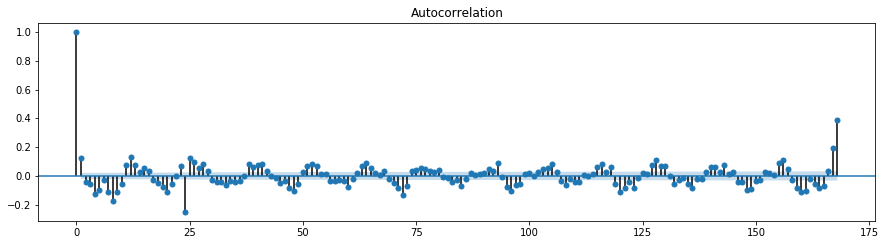

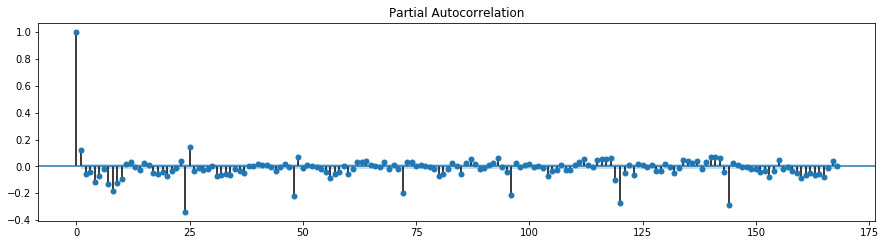

In [27]:
ACF_PACF(data_agg_ESB['diff_'][25:].values.squeeze())

#### Начальные приближения для параметров

In [28]:
D, d = 1, 1

P, p = 0, 1
Ps = range(0, P+1)
ps = range(0, p+1)

Q, q = 1, 7
Qs = range(0, Q+1)
qs = range(0, q+1)

In [29]:
from itertools import product

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

32

In [30]:
%%time

results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
endog = data_agg_ESB['residuals']
exog = data_agg_ESB.loc[:,['s1', 'c1', 's2', 'c2', 's3', 'c3', 's4', 'c4',]]


for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(endog, exog, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 24)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

('wrong parameters:', (0, 0, 0, 0))
('wrong parameters:', (1, 2, 0, 0))
('wrong parameters:', (1, 2, 0, 1))
('wrong parameters:', (1, 4, 0, 0))
('wrong parameters:', (1, 4, 0, 1))
Wall time: 4h 43s


#### Модель с минимальным значением AIC

In [31]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head(1))

      parameters            aic
12  (0, 6, 0, 1)  103402.399069


In [32]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                          residuals   No. Observations:                 8762
Model:             SARIMAX(0, 1, 6)x(0, 1, 1, 24)   Log Likelihood              -51685.200
Date:                            Tue, 03 Jul 2018   AIC                         103402.399
Time:                                    23:35:15   BIC                         103515.650
Sample:                                05-01-2016   HQIC                        103440.987
                                     - 05-31-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
s1         -1.565e-06    119.700  -1.31e-08      1.000    -234.607     234.607
c1         -4.253e-05   3200.078  -

#### Анализ остатков

Критерий Стьюдента: p=0.951705
Критерий Дики-Фуллера: p=0.000000


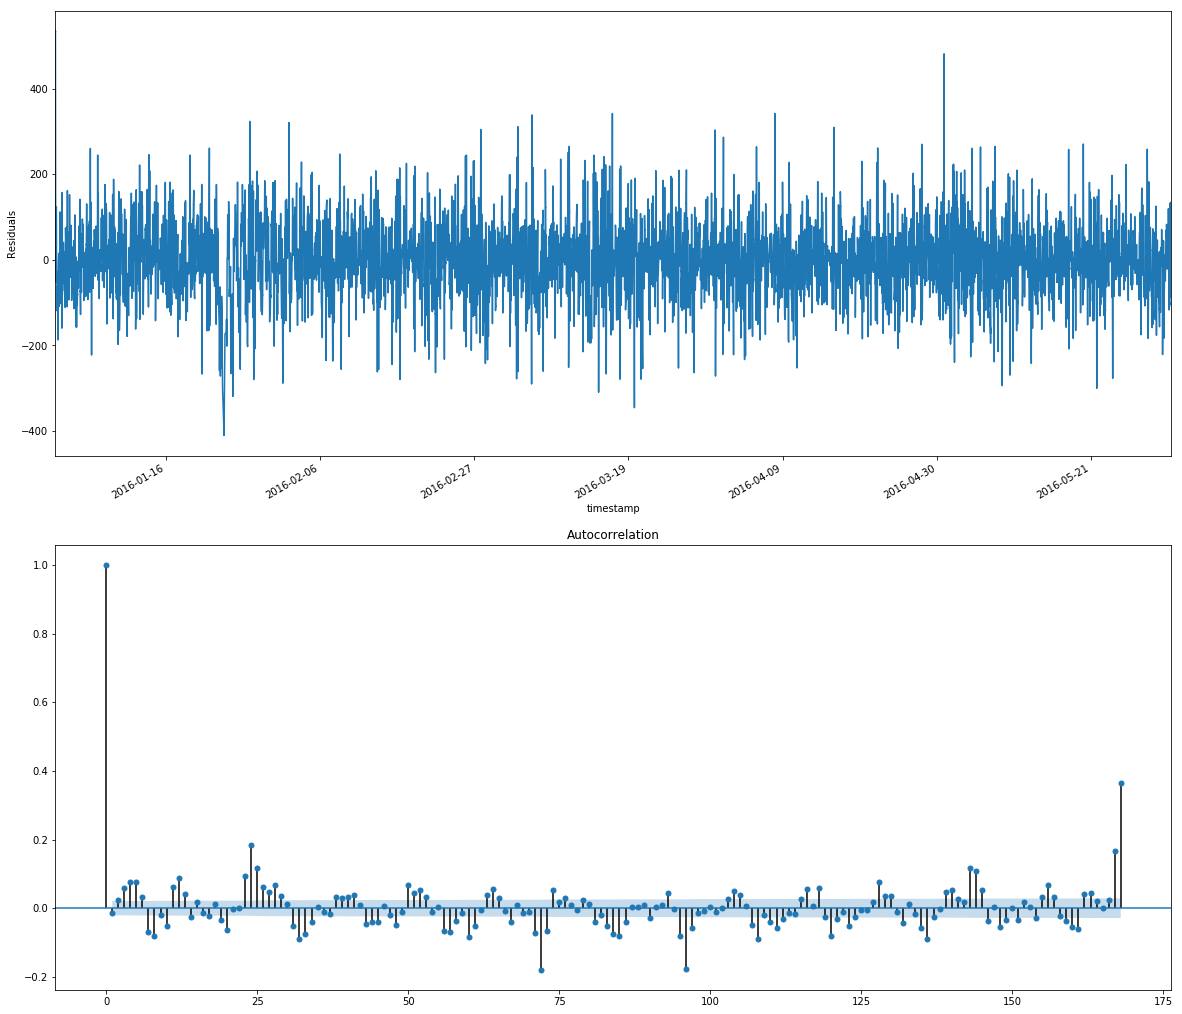

In [33]:
plt.figure(figsize(20,20))
plt.subplot(211)
best_model.resid[25:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[25:].values.squeeze(), lags=168, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[25:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[25:])[1])

#### Остатки несмещены (подтверждается критерием Стьюдента p=0.911189) стационарны (подтверждается критерием Дики-Фуллера p=0.000000 и визуально)

#### Посмотрим, насколько хорошо модель описывает данные

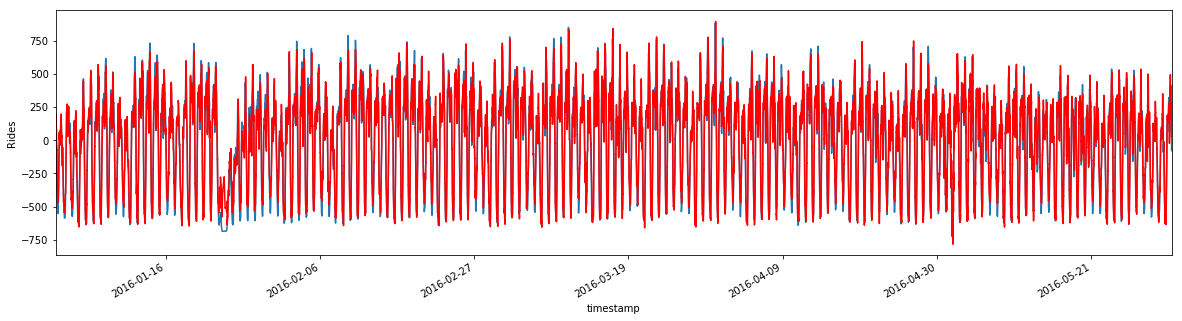

In [34]:
data_agg_ESB['model'] = best_model.fittedvalues
plt.figure(figsize(20,5))
data_agg_ESB['residuals'].plot()
data_agg_ESB.model.plot(color='r')
plt.ylabel('Rides')
pylab.show()

В принципе, модель хорошо опиcывает данные, но недельную сезонность не удалось до конца описать. Возможно при формировании признаков стоит брать значения К больше 4.

In [35]:
data_agg_ESB = pd.read_csv('data_agg_ESB.csv', header = 0, sep=',', index_col=['timestamp'], parse_dates=['timestamp'])

# Удаляем лишние заголовки
data_agg_ESB.drop(data_agg_ESB.loc[data_agg_ESB['region_id'] == 'region_id'].index, axis = 0, inplace = True)

# Убираем индекс зоны, поскольку мы выбрали одну конкретную
data_agg_ESB.drop(['region_id'], axis=1, inplace=True)

# Приводим к необходимому типу данных
data_agg_ESB['counts'] = pd.to_numeric(data_agg_ESB['counts'])
data_agg_ESB.index = pd.to_datetime(data_agg_ESB.index)

data_agg_ESB.head()

counts
timestamp                  
2016-05-01 00:00:00     881
2016-05-01 01:00:00     713
2016-05-01 02:00:00     533
2016-05-01 03:00:00     418
2016-05-01 04:00:00     353

In [36]:
# Регрессионные признаки
K=7
p = 2.*pi/168. # 168 — длительность недели в часах
for T in range(1, K+1):
    phi = p*T
    data_agg_ESB['s'+str(T)] = sin(T*phi)
    data_agg_ESB['c'+str(T)] = cos(T*phi)
data_agg_ESB.head()

counts        s1        c1        s2        c2        s3  \
timestamp                                                                       
2016-05-01 00:00:00     881  0.037391  0.999301  0.149042  0.988831  0.330279   
2016-05-01 01:00:00     713  0.037391  0.999301  0.149042  0.988831  0.330279   
2016-05-01 02:00:00     533  0.037391  0.999301  0.149042  0.988831  0.330279   
2016-05-01 03:00:00     418  0.037391  0.999301  0.149042  0.988831  0.330279   
2016-05-01 04:00:00     353  0.037391  0.999301  0.149042  0.988831  0.330279   

                           c3       s4        c4        s5       c5        s6  \
timestamp                                                                       
2016-05-01 00:00:00  0.943883  0.56332  0.826239  0.804598  0.59382  0.974928   
2016-05-01 01:00:00  0.943883  0.56332  0.826239  0.804598  0.59382  0.974928   
2016-05-01 02:00:00  0.943883  0.56332  0.826239  0.804598  0.59382  0.974928   
2016-05-01 03:00:00  0.943883  0.56332  0.826239  0.804598  0.59382  0.974928   
2016-05-01 04:00:00  0.943883  0.56332  0.826239  0.804598  0.59382  0.974928   

                           c6        s7        c7  
timestamp                                          
2016-05-01 00:00:00  0.222521  0.965926 -0.258819  
2016-05-01 01:00:00  0.222521  0.965926 -0.258819  
2016-05-01 02:00:00  0.222521  0.965926 -0.258819  
2016-05-01 03:00:00  0.222521  0.965926 -0.258819  
2016-05-01 04:00:00  0.222521  0.965926 -0.258819

Text(0.5,0,u'\u0412\u0440\u0435\u043c\u044f')

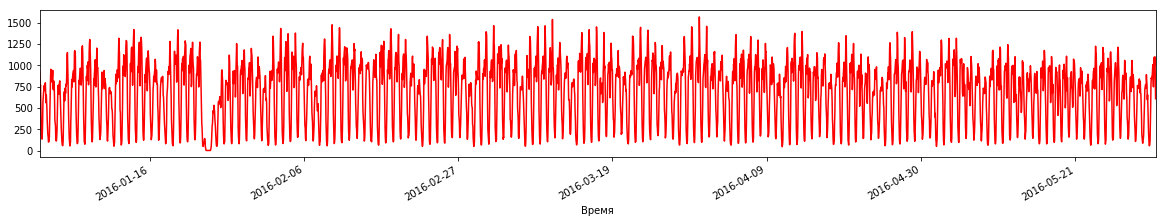

In [37]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(data_agg_ESB.iloc[:, 1:], data_agg_ESB.counts)
predictions = lr.predict(data_agg_ESB.iloc[:, 1:])
residuals = data_agg_ESB.counts-predictions

plt.figure(figsize=(20,3))
residuals.plot(color='red')
plt.xlabel(u'Время')

In [38]:
Hypothesis_testing(residuals)

Критерий Дики-Фуллера: p=0.000000, отвергает гипотезу о нестационарности
Q-тест Льюнг — Бокса случайности данных: p=40.000000, отвергает гипотезу о случайности данных
Критерий Стьюдента для несмещенности: p=0.000000, отвергает гипотезу равенства среднего 0


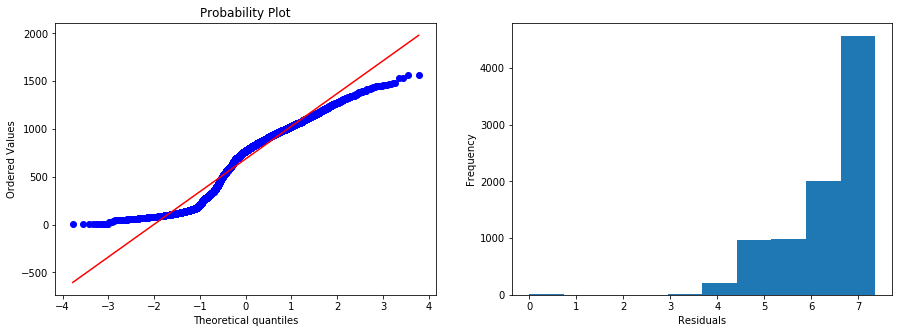

In [39]:
QQ_chart_and_residuals(residuals)

### При К = 7 Критерий Дики-Фуллера, не отвергает гипотезу о нестационарности, тогда как при К = 4 отвергал гипотезу. Предлагается взять K < 4.

In [40]:
data_agg_ESB = pd.read_csv('data_agg_ESB.csv', header = 0, sep=',', index_col=['timestamp'], parse_dates=['timestamp'])

# Удаляем лишние заголовки
data_agg_ESB.drop(data_agg_ESB.loc[data_agg_ESB['region_id'] == 'region_id'].index, axis = 0, inplace = True)

# Убираем индекс зоны, поскольку мы выбрали одну конкретную
data_agg_ESB.drop(['region_id'], axis=1, inplace=True)

# Приводим к необходимому типу данных
data_agg_ESB['counts'] = pd.to_numeric(data_agg_ESB['counts'])
data_agg_ESB.index = pd.to_datetime(data_agg_ESB.index)

data_agg_ESB.head()

counts
timestamp                  
2016-05-01 00:00:00     881
2016-05-01 01:00:00     713
2016-05-01 02:00:00     533
2016-05-01 03:00:00     418
2016-05-01 04:00:00     353

In [41]:
# Регрессионные признаки
K=2
p = 2.*pi/168. # 168 — длительность недели в часах
for T in range(1, K+1):
    phi = p*T
    data_agg_ESB['s'+str(T)] = sin(T*phi)
    data_agg_ESB['c'+str(T)] = cos(T*phi)
data_agg_ESB.head()

counts        s1        c1        s2        c2
timestamp                                                          
2016-05-01 00:00:00     881  0.037391  0.999301  0.149042  0.988831
2016-05-01 01:00:00     713  0.037391  0.999301  0.149042  0.988831
2016-05-01 02:00:00     533  0.037391  0.999301  0.149042  0.988831
2016-05-01 03:00:00     418  0.037391  0.999301  0.149042  0.988831
2016-05-01 04:00:00     353  0.037391  0.999301  0.149042  0.988831

Text(0.5,0,u'\u0412\u0440\u0435\u043c\u044f')

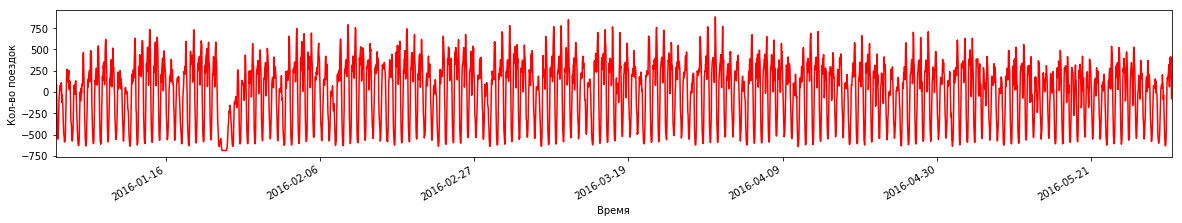

In [42]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(data_agg_ESB.iloc[:, 1:], data_agg_ESB.counts)
predictions = lr.predict(data_agg_ESB.iloc[:, 1:])
residuals = data_agg_ESB.counts-predictions

plt.figure(figsize=(20,3))
residuals.plot(color='red')
plt.ylabel(u'Кол-во поездок')
plt.xlabel(u'Время')

In [43]:
Hypothesis_testing (residuals)

Критерий Дики-Фуллера: p=0.000000, отвергает гипотезу о нестационарности
Q-тест Льюнг — Бокса случайности данных: p=40.000000, отвергает гипотезу о случайности данных
Критерий Стьюдента для несмещенности: p=1.000000, не отвергает гипотезу равенства среднего 0


C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log
  import sys


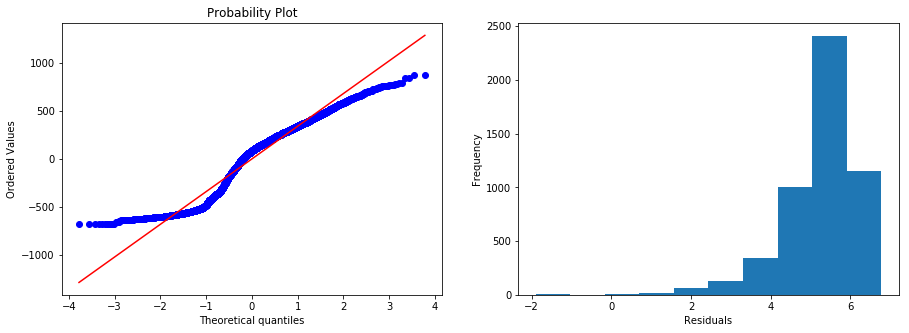

In [44]:
QQ_chart_and_residuals(residuals)

In [45]:
data_agg_ESB['residuals'] = residuals

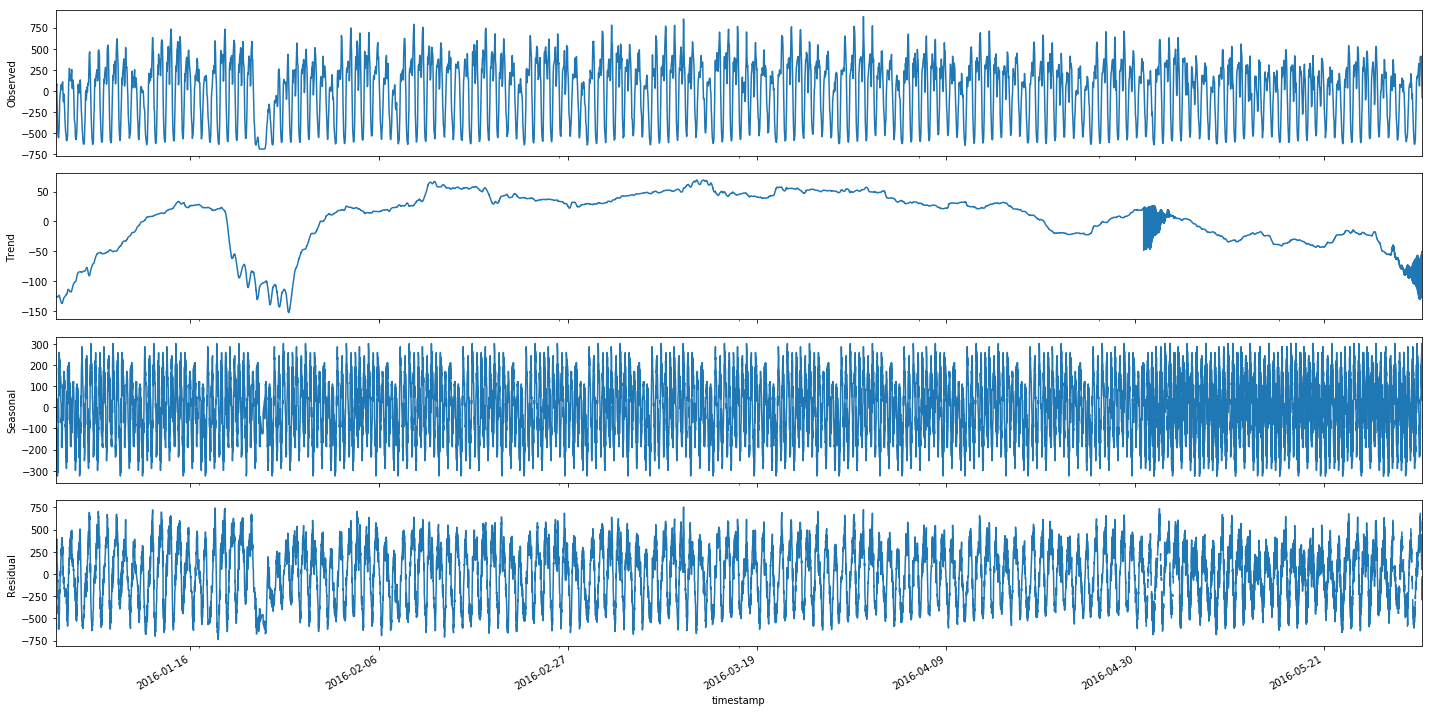

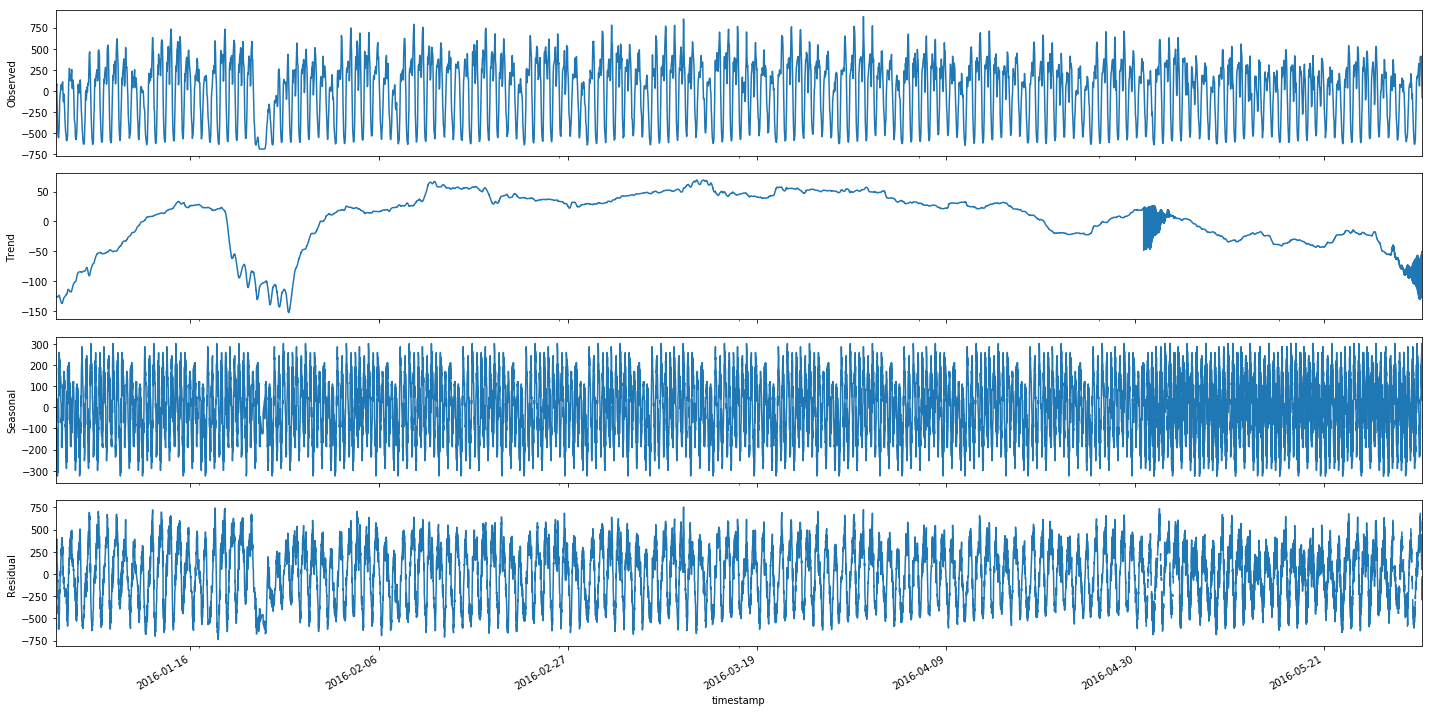

In [46]:
plt.figure(figsize(20,10))
sm.tsa.seasonal_decompose(data_agg_ESB['residuals'], freq = 168).plot()

Критерий Дики-Фуллера: p=0.000000


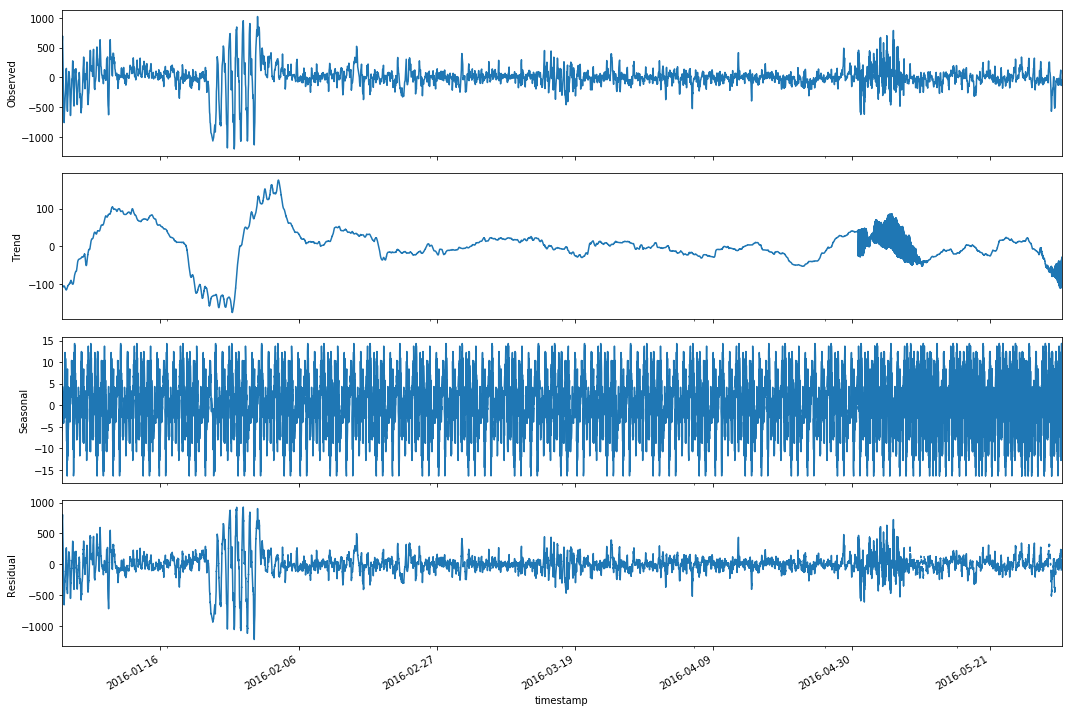

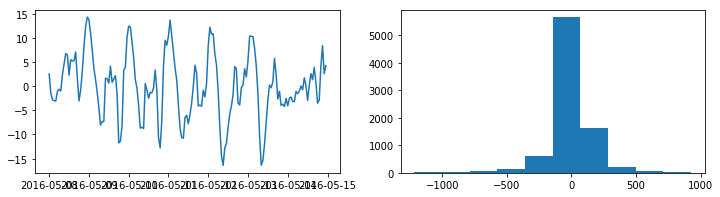

In [49]:
data_agg_ESB['diff_168'] = data_agg_ESB['residuals'] - data_agg_ESB['residuals'].shift(168)
    
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data_agg_ESB['diff_168'][168:], freq = 168).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data_agg_ESB['diff_168'][168:])[1])
    
fig = plt.figure(figsize = (12,3))
ax = fig.add_subplot(121)
plt.plot(sm.tsa.seasonal_decompose(data_agg_ESB['diff_168'][168:], freq = 168).seasonal[:168])
ax = fig.add_subplot(122)
plt.hist(sm.tsa.seasonal_decompose(data_agg_ESB['diff_168'][168:], freq = 168).resid[84:-84])
plt.show()

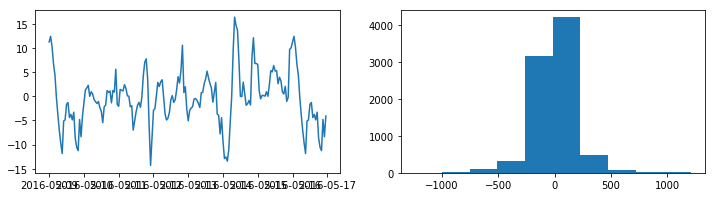

In [50]:
data_agg_ESB['diff_'] = data_agg_ESB['diff_168'] - data_agg_ESB['diff_168'].shift(24)
fig = plt.figure(figsize = (12,3))
ax = fig.add_subplot(121)
plt.plot(sm.tsa.seasonal_decompose(data_agg_ESB['diff_'][192:], freq = 168).seasonal[:192])
ax = fig.add_subplot(122)
plt.hist(sm.tsa.seasonal_decompose(data_agg_ESB['diff_'][192:], freq = 168).resid[96:-96])
plt.show()

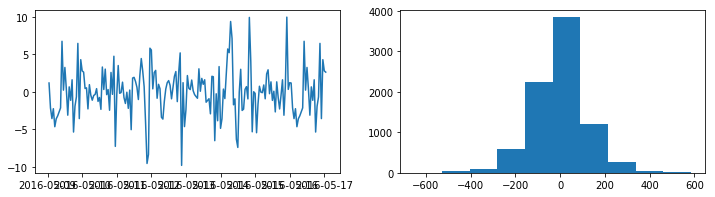

In [51]:
data_agg_ESB['diff_'] = data_agg_ESB['diff_'] - data_agg_ESB['diff_'].shift(1)
fig = plt.figure(figsize = (12,3))
ax = fig.add_subplot(121)
plt.plot(sm.tsa.seasonal_decompose(data_agg_ESB['diff_'][193:], freq = 168).seasonal[:193])
ax = fig.add_subplot(122)
plt.hist(sm.tsa.seasonal_decompose(data_agg_ESB['diff_'][193:], freq = 168).resid[96:-96])
plt.show()

#### Использовали недельное, дневное и обычное дифференцирование, остатки выглядят лучше чем в изначальном варианте

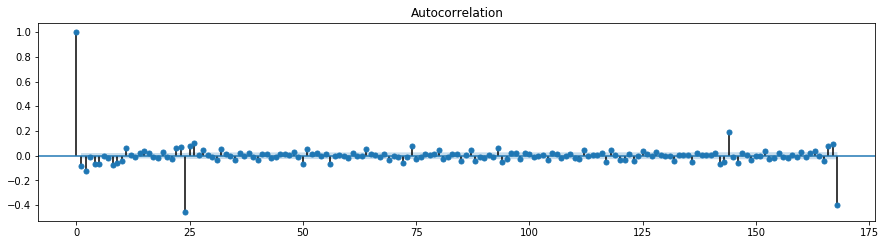

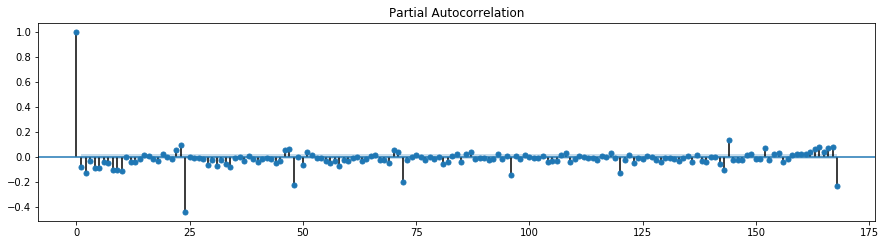

In [52]:
ACF_PACF(data_agg_ESB['diff_'][193:].values.squeeze())

#### В остатках стало меньше значимых лагов, график без явных периодичностей.

In [114]:
D, d = 2, 1

P, p = 1, 2
Ps = range(0, P+1)
ps = range(0, p+1)

Q, q = 1, 2
Qs = range(0, Q+1)
qs = range(0, q+1)

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

36

In [115]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
endog = data_agg_ESB['residuals']
exog = data_agg_ESB.loc[:,['s1', 'c1', 's2', 'c2']]


for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(endog, exog, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 24)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

('wrong parameters:', (0, 0, 0, 0))
('wrong parameters:', (2, 2, 0, 0))
('wrong parameters:', (2, 2, 0, 1))
('wrong parameters:', (2, 2, 1, 0))
('wrong parameters:', (2, 2, 1, 1))
Wall time: 6h 8min 48s


In [116]:
model.save(fname='SARIMAX_MODEL')

In [117]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head(1))

      parameters            aic
30  (2, 1, 1, 1)  104933.734163


In [118]:
print best_model.summary()

                                 Statespace Model Results                                 
Dep. Variable:                          residuals   No. Observations:                 8762
Model:             SARIMAX(2, 1, 1)x(1, 2, 1, 24)   Log Likelihood              -52456.867
Date:                            Fri, 06 Jul 2018   AIC                         104933.734
Time:                                    23:08:14   BIC                         105004.516
Sample:                                05-01-2016   HQIC                        104957.852
                                     - 05-31-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
s1           8.87e-06    164.165    5.4e-08      1.000    -321.758     321.758
c1             0.0002   4289.368   

Критерий Стьюдента: p=0.867722
Критерий Дики-Фуллера: p=0.000000


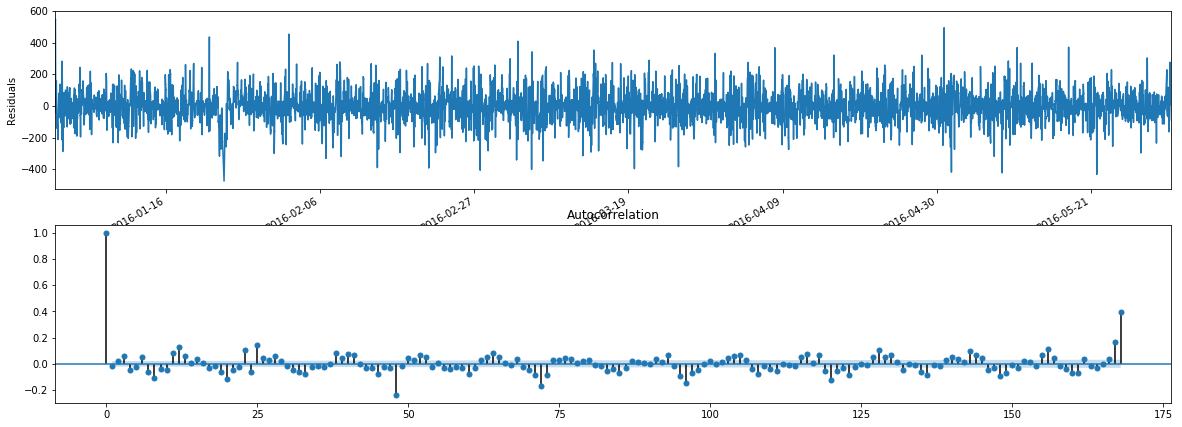

In [119]:
plt.figure(figsize(20,8))
plt.subplot(211)
best_model.resid[193:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[193:].values.squeeze(), lags=168, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[193:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[193:])[1])

#### По графикам можно сказать что остатки имеют большую несмещённость и у автокорреляционной функции меньше значимых лагов

In [120]:
model.load(fname='SARIMAX_MODEL')

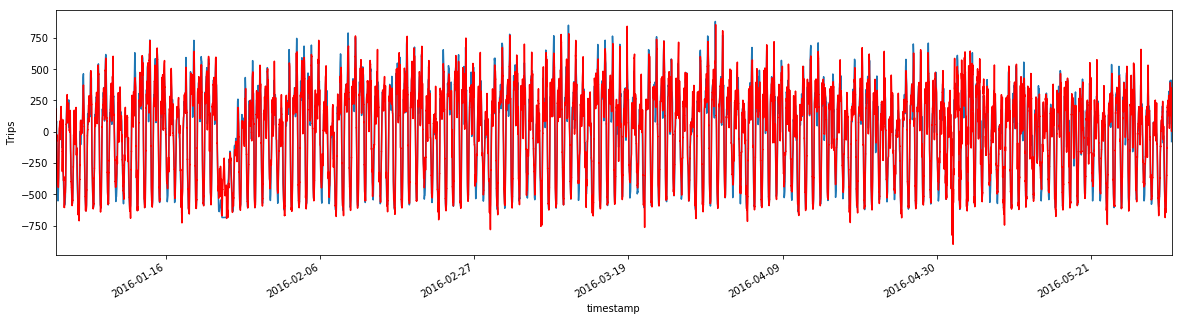

In [121]:
data_agg_ESB['model'] = best_model.fittedvalues
plt.figure(figsize(20,5))
data_agg_ESB['residuals'].plot()
data_agg_ESB.model.plot(color='r')
plt.ylabel('Trips')
pylab.show()

#### Вывод: Изначальная модель не до конца описывала выходные дни, субботу и воскресенье (1, 7, 8, 14, 15, 21, 22, 28, 29). Данная модель стала лучше описывать воскресенье, но ухудшились показатели по понедельнику. Полагаю, для более лучшего моделирования стоит вводить другие признаки, например признаки дней недели.

#### По результатам моделирования видно что у косинусов большая ошибка, возможно стоит построить модель без них

In [123]:
D, d = 2, 1

P, p = 0, 1
Ps = range(0, P+1)
ps = range(0, p+1)

Q, q = 1, 2
Qs = range(0, Q+1)
qs = range(0, q+1)

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

12

In [124]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
endog = data_agg_ESB['residuals']
exog = data_agg_ESB.loc[:,['s1','s2']]


for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(endog, exog, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 24)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

('wrong parameters:', (0, 0, 0, 0))
Wall time: 1h 21min 24s


In [125]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head(1))

      parameters            aic
10  (1, 2, 0, 1)  105835.814201


In [126]:
print best_model.summary()

                                 Statespace Model Results                                 
Dep. Variable:                          residuals   No. Observations:                 8762
Model:             SARIMAX(1, 1, 2)x(0, 2, 1, 24)   Log Likelihood              -52910.907
Date:                            Sat, 07 Jul 2018   AIC                         105835.814
Time:                                    08:33:27   BIC                         105885.361
Sample:                                05-01-2016   HQIC                        105852.696
                                     - 05-31-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
s1          4.385e-06   1.55e+04   2.84e-10      1.000   -3.03e+04    3.03e+04
s2         -8.994e-07   6.14e+04  -

Критерий Стьюдента: p=0.929365
Критерий Дики-Фуллера: p=0.000000


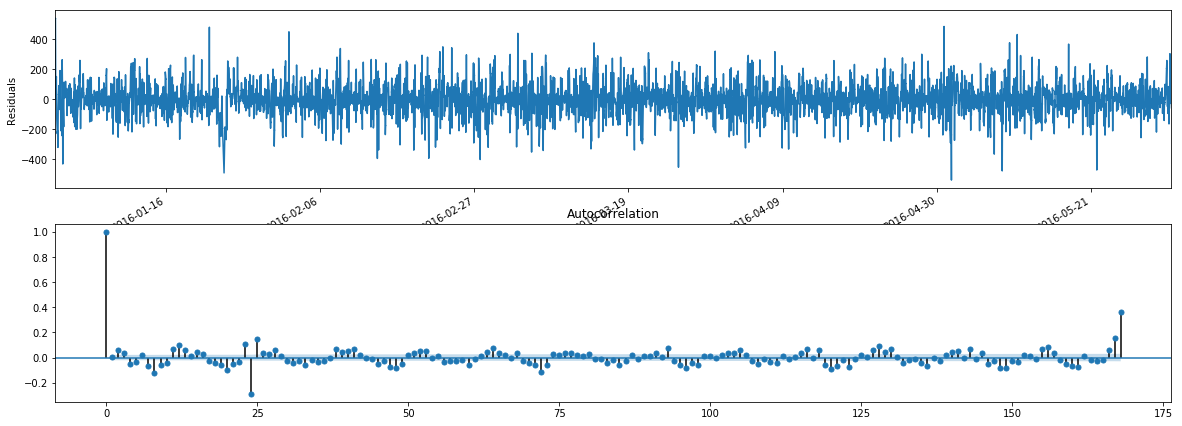

In [127]:
plt.figure(figsize(20,8))
plt.subplot(211)
best_model.resid[193:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[193:].values.squeeze(), lags=168, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[193:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[193:])[1])

#### При моделировании только с синусами визуально значимых различий не видно

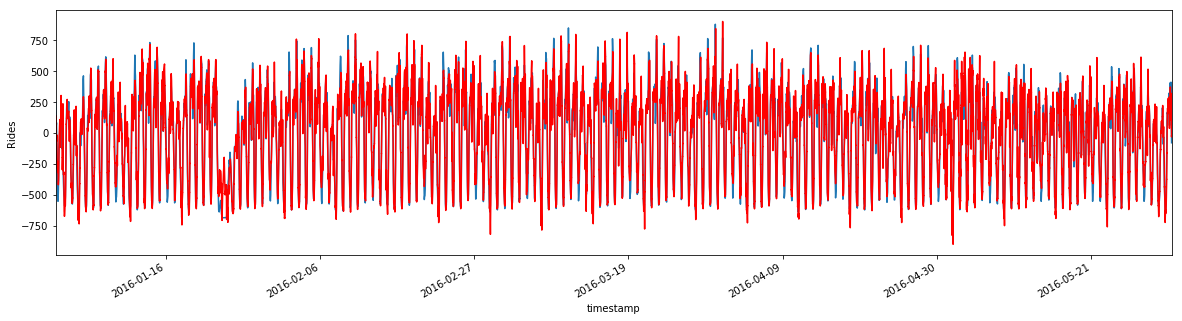

In [128]:
data_agg_ESB['model'] = best_model.fittedvalues
plt.figure(figsize(20,5))
data_agg_ESB['residuals'].plot()
data_agg_ESB.model.plot(color='r')
plt.ylabel('Rides')
pylab.show()